<a href="https://colab.research.google.com/github/khalil-alexander/get_forecast/blob/main/recent_DataAnalytics2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color="red"> Pip install Astropy in google colab <font/>
### <font color="Green"> We install astropy in order to convert kilometre to longitatide later <font/>

In [1]:
!pip install astropy
!pip install country_converter
!pip install shapely
!pip install cartopy
!pip install geopandas
!pip install movingpandas
!pip install hvplot
!pip install holoviews
!pip install geoviews
!pip install global_land_mask
!pip install reverse_geocode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.3/547.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.3 MB/s eta 0:00:00


## <font color="red"> Install Moudles in google colab <font/>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from astropy import coordinates as coord
from astropy import units as u
from astropy import time
from astropy.time import Time
from astropy.coordinates import Angle

In [4]:
import pandas as pd
from bs4 import BeautifulSoup
import requests as reqs
import xml.etree.ElementTree as ET
import io
import pprint
import json
import datetime

In [5]:
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from geopy.geocoders import Nominatim

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as mcm

In [7]:
import cartopy
import cartopy.crs as ccrs
import country_converter as coco
from cartopy.feature.nightshade import Nightshade
from global_land_mask import globe

In [8]:
from shapely import geometry as shpgeom
from shapely import wkt as shpwkt

In [9]:
import holoviews as hv
import hvplot.pandas
import geoviews

In [10]:
import os
from pathlib import Path
import datetime as dt
from datetime import timezone

In [11]:
from datetime import datetime
import datetime as dt
from datetime import timezone

In [12]:
import xarray as xr

In [13]:
from global_land_mask import globe
import reverse_geocode

In [14]:
import seaborn as sns

In [15]:
def create_latlon_positions(date: str, xyz: list[float]):
    now = Time(date, scale='utc')
    cartrep = coord.CartesianRepresentation(*xyz, unit=u.km)

    gcrs = coord.GCRS(cartrep, obstime = now)
    itrs = gcrs.transform_to(coord.ITRS(obstime = now))
    loc = coord.EarthLocation(*itrs.cartesian.xyz)

    return Angle(loc.lat).deg, Angle(loc.lon).deg


In [16]:
def get_latlon(row: pd.Series):
    date = row['Date'].strftime('%Y-%m-%d %H:%M:%S')
    xyz = [row['x units(km)'], row['y units(km)'], row['z units(km)']]
    return create_latlon_positions(date, xyz)




## <font color="red"> read_xml_DateFrame <font/>
### <font color="green">A function that reads an xml file and returns the specfic position the ISS is at during different time. <font/>

<font color="blue"> We pass in the url of an XML file:https://nasa-public-data.s3.amazonaws.com/iss-coords/current/ISS_OEM/ISS.OEM_J2K_EPH.xml
<font color="blue"> We use the XML file to webscrap data on the the position of the ISS and time the ISS was in that posistion.

<font color="blue"> In order to clean up the data we use Beautifulsoup

### <font color="green">What is Beautifulsoup? <font/>

<font color="blue">Beautifulsoup is a python libary that is used to pull XML and HTML files. In this case we want to pull out an XML file. <font/>

<font color="blue">The XML file we used to extract data from: https://nasa-public-data.s3.amazonaws.com/iss-coords/current/ISS_OEM/ISS.OEM_J2K_EPH.xml <font/>

In [17]:
def read_xml_DataFrame(url):
    """
    Do web scraping from an XML file to obtain time the International Space
    Station will be at a specfic postion and the speed it is going at.

    Parameters
    ----------
    url : String
        The url of the data in XML format you want to extract from.

    Return
    ------
    df : Pandas DataFrame
        The DataFrame containing the time the International Space Station is at
        a specfic position and the speed it is traveling.
    """
    # Get the xml request
    xml = reqs.get(url)

    # Use BeautifulSoup to Organize the XML file
    soup = BeautifulSoup(xml.content,"lxml")

    # Finds all the instances 'statevector' appeared in the xml file
    state_tag = soup.find_all('statevector')

    col_name = ['Date','x units(km)',
                'y units(km)','z units(km)',
                'x_dot(km/s)',
                'y_dot(km/s)','z_dot(km/s)']
    df = pd.DataFrame(columns=col_name)

    #Loops thorugh all elements to add rows in the empty xml_df
    for element in state_tag:
        # Turns element into text and splits the '\n'
        element = element.text.split('\n')
        # Deletes First empty String
        element.pop(0)
        # Deletes Last empty Sting
        element.pop(-1)
        # Removes the 'Z' in the elements first index
        element[0] = element[0][:-1]

        # Appending list into DataFrame by adding 1 row to the DataFrame
        #df = xml_df.append(pd.DataFrame(element, columns=col_name), ignore_index=True)
        df.loc[len(df)] = element


    # Turns the "Date" collumn into a Datetime object
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%jT%H:%M:%S.%f')
    # Sets the "Date" collumn into a Datetime object
    #df.set_index("Date", inplace=True)

    # Returns the Dataframe
    return df

In [18]:
xml_url = "https://nasa-public-data.s3.amazonaws.com/iss-coords/current/ISS_OEM/ISS.OEM_J2K_EPH.xml"
%time df = read_xml_DataFrame(xml_url)

CPU times: user 8.58 s, sys: 155 ms, total: 8.74 s
Wall time: 9.54 s


In [19]:
df

,Date,x units(km),y units(km),z units(km),x_dot(km/s),y_dot(km/s),z_dot(km/s)
0,2025-04-04 12:00:00,4907.3235812702496,100.78437963294,4690.50177842223,-2.8323570101796198,6.5406777239195,2.8201546307357002
1,2025-04-04 12:04:00,4057.2935752694202,1647.7996900409501,5187.9634261682404,-4.2077953671826798,6.2724177565336996,1.3001545177449501
2,2025-04-04 12:08:00,2912.1864995984802,3074.98635947805,5307.0493695139303,-5.2764299844022702,5.54827666032031,-0.31370941070390002
3,2025-04-04 12:12:00,1555.39164666189,4278.6540535162103,5039.2636102476899,-5.9611862001933096,4.4211280287487096,-1.9041263171930201
4,2025-04-04 12:16:00,85.562713371614805,5171.3681830486003,4404.2068916485496,-6.2126692043764598,2.9727639352637198,-3.3556485777695402
...,...,...,...,...,...,...,...
5398,2025-04-19 11:46:00,900.92000713853497,5985.7038438298596,-3103.2876039101898,-5.6618424525241497,-1.66757260095195,-4.8707433565479699
5399,2025-04-19 11:50:00,-474.11481779663802,5373.4608952133804,-4145.3263011638701,-5.7270793008499803,-3.4029759453440001,-3.7602392400639402
5400,2025-04-19 11:54:00,-1814.8443678296401,4372.2126313688104,-4886.44934117106,-5.3778847100290701,-4.8897928288009203,-2.3784467399634202
5401,2025-04-19 11:58:00,-3024.35290441299,3054.8119284341301,-5273.2550944630102,-4.6402723147720799,-6.0218258871982,-0.82547100810231


In [20]:
df[['lat','lon']] = df.apply(get_latlon, axis=1, result_type='expand')

In [21]:
df = df[['Date','lat','lon']]

In [22]:
df

,Date,lat,lon
0,2025-04-04 12:00:00,44.020853,-11.557049
1,2025-04-04 12:04:00,50.141197,8.427171
2,2025-04-04 12:08:00,51.683332,31.944275
3,2025-04-04 12:12:00,48.134005,54.425880
4,2025-04-04 12:16:00,40.598278,72.426740
...,...,...,...
5398,2025-04-19 11:46:00,-27.266370,57.360652
5399,2025-04-19 11:50:00,-37.725036,69.922871
5400,2025-04-19 11:54:00,-46.140094,86.393131
5401,2025-04-19 11:58:00,-51.087085,107.570938


In [23]:
def create_latlon_positions(date: str, xyz: list[float]):
    now = Time(date, scale='utc')
    cartrep = coord.CartesianRepresentation(*xyz, unit=u.km)

    gcrs = coord.GCRS(cartrep, obstime = now)
    itrs = gcrs.transform_to(coord.ITRS(obstime = now))
    loc = coord.EarthLocation(*itrs.cartesian.xyz)

    return Angle(loc.lat).deg, Angle(loc.lon).deg


In [24]:
def get_latlon(row: pd.Series):
    date = row['Date'].strftime('%Y-%m-%d %H:%M:%S')
    xyz = [row['x units(km)'], row['y units(km)'], row['z units(km)']]
    return create_latlon_positions(date, xyz)




In [25]:
# Writing a function to return if there is land in a given latitude/longitude
# Function returns 1 if there is land and returns 0 if there is ocean.
def get_land_flag(row):
    """
    Extract the land_flag given the latitude/longitude information.
    This function provides if there is land in a given latitude/longitude. If
    not then we can assume the given latitude/longitude is on the ocean.

    Parameters
    ----------
    lat : float
       Latitude of the location
    lon : float
       Longitude of the location

    Returns
    -------
    land_flag : boolen
       If land_flag is true or not
    """
    # Gets checks if there is land in the given latitude/longitude
    land_flag = globe.is_land(row['lat'],row['lon'])
    # Returns land flag
    return land_flag

In [26]:
# Getting the name of a country with latitude/longitude
# Returns the name of the country
def get_country_name(lat: float, lon: float) -> str:
    """
    Extract the country name given the latitude/longitude information.
    This function provides a country name even when a location is on
    the ocean. We wish it was not the case.

    Parameters
    ----------
    lat : float
       Latitude of the location
    lon : float
       Longitude of the location

    Returns
    -------
    country : str
       Country name (empty string if no country)
    """
    # Turn latitude and longitude into a tuple
    lat_lon = (lat, lon),
    # Get location with geocode
    loc_name = reverse_geocode.search(lat_lon)
    # Returns Country name
    return loc_name[0].get('country', '')

In [27]:
# Using the function get_county_name we obtain the country if land_flag is true
# Returns name of country if land_flag is true, otherwise returns 'Ocean'
def obtain_country_name(row):
    """
    Extract the country name given the latitude/longitude information.
    This function provides a country name even when a location is on
    the ocean. We wish it was not the case.

    Parameters
    ----------
    row: Pandas Dataframe
       Dataframe expected to contain the latitude and longitude

       lat : float
         Latitude of the location
       lon : float
         Longitude of the location

    Returns
    -------
    country : str
       Country name (empty string if no country)
    """
    # Checks if land_flag is true
    if row['land_flag'] == 1:
        # Gets latitude and longitude
        lat = row['lat']
        lon = row['lon']
        # Gets country name
        country = get_country_name(lat, lon)
        # Retuns country name
        return country
    else:
        # Returns ocean if land_flag is false
        return "Ocean"

In [28]:
def get_overpassed_countries(df: pd.DataFrame, country_dict: dict):
    """
    Counts the amount of countrys the ISS flys over.

    Parameters
    ----------
    df : Pandas DataFrame

    Return
    ------
    count : Int
        The number of countrys the ISS flys over.
    """
    list_countries = df["Country"].unique().tolist()
    list_countries.remove("Ocean")

    for country in list_countries:
        if country in country_dict:
            country_dict[country] += 1
        else:
            country_dict[country] = 1
    return country_dict


In [29]:
def count_countrys(df: pd.DataFrame):
    """
    Counts the amount of countrys the ISS flys over.

    Parameters
    ----------
    df : Pandas DataFrame

    Return
    ------
    count : Int
        The number of countrys the ISS flys over.
    """
    country_dict = {}
    previous_name = ""
    country_count = 0
    for name, land_flag in zip(df['Country'], df['land_flag']):
        if (previous_name != name) and (name not in country_dict) and land_flag == True:
            if name not in country_dict:
                country_dict[name] = 1
                country_count += 1

        previous_name = name
    print(country_dict)
    print(country_count)
    return country_count


In [154]:
def create_list_orbits(df: pd.DataFrame) -> list:
    """

    """
    list_orbits = list()
    temp_df = df['lon']
    first_index = 0
    second_index = 0


    for i in range(len(temp_df)-1):
        if (temp_df[i] > 0) and (temp_df[i+1] < 0):
            second_index = i+1
            list_orbits.append(df[first_index:second_index])
            first_index = second_index

    list_orbits.append(df[second_index:])


    return list_orbits

In [155]:
def get_interpolated_data(df: pd.DataFrame, seconds='20s') -> pd.DataFrame:
    """

    """

    df.rename(columns={'Date': 't'}, inplace=True)

    df.set_index('t', inplace=True)
    ds = df.to_xarray()

    start_date = df.index[0] + dt.timedelta(seconds=5)
    start_date = datetime.fromtimestamp(start_date.timestamp())
    start_date = start_date.strftime('%Y-%m-%dT%H:%M:%S')

    end_date = df.index[-1] - dt.timedelta(seconds=5)
    end_date = datetime.fromtimestamp(end_date.timestamp())
    end_date = end_date.strftime('%Y-%m-%dT%H:%M:%S')

    new_dates = pd.date_range(start_date, end_date, freq=seconds)
    interpolated_data = ds.interp(t=new_dates, method='linear')
    interpolated_df = interpolated_data.to_dataframe()

    return interpolated_df

In [156]:
def get_interpolated_data2(df: pd.DataFrame, seconds='20s') -> pd.DataFrame:
    ds = df.to_xarray()

    start_date = df.index[0] + dt.timedelta(seconds=5)
    start_date = datetime.fromtimestamp(start_date.timestamp())
    start_date = start_date.strftime('%Y-%m-%dT%H:%M:%S')

    end_date = df.index[-1] - dt.timedelta(seconds=5)
    end_date = datetime.fromtimestamp(end_date.timestamp())
    end_date = end_date.strftime('%Y-%m-%dT%H:%M:%S')

    new_dates = pd.date_range(start_date, end_date, freq=seconds)
    interpolated_data = ds.interp(t=new_dates, method='linear')
    interpolated_df = interpolated_data.to_dataframe()

    return interpolated_df


In [157]:
def interpolate_orbits(df_list: list, seconds='20s') -> list:
    count = 0
    new_df_list = list()
    for element in df_list:
        element = get_interpolated_data(element, seconds)
        element['land_flag'] = element.apply(get_land_flag, axis=1, result_type='expand')
        element['Country'] = element.apply(obtain_country_name, axis=1, result_type='expand')
        new_df_list.append(element)


    return new_df_list



In [158]:
def interpolate_orbits2(df_list: list, seconds='20s') -> list:
    count = 0
    new_df_list = list()
    for element in df_list:
        element = get_interpolated_data2(element, seconds)
        element['land_flag'] = element.apply(get_land_flag, axis=1, result_type='expand')
        element['Country'] = element.apply(obtain_country_name, axis=1, result_type='expand')
        new_df_list.append(element)


    return new_df_list



In [159]:
def get_all_countrys(df_list: list) -> dict:
    """

    """
    country_dict = dict()
    for df in df_list:
        country_dict = get_overpassed_countries(df, country_dict)
    return country_dict

In [34]:
orbit_list = create_list_orbits(df)

In [35]:
orbit_list

[                  Date        lat         lon
 0  2025-04-04 12:00:00  44.020853  -11.557049
 1  2025-04-04 12:04:00  50.141197    8.427171
 2  2025-04-04 12:08:00  51.683332   31.944275
 3  2025-04-04 12:12:00  48.134005   54.425880
 4  2025-04-04 12:16:00  40.598278   72.426740
 5  2025-04-04 12:20:00  30.618463   86.069367
 6  2025-04-04 12:24:00  19.299609   96.818041
 7  2025-04-04 12:28:00   7.315812  106.002260
 8  2025-04-04 12:32:00  -4.886454  114.644552
 9  2025-04-04 12:36:00 -16.934688  123.637088
 10 2025-04-04 12:40:00 -28.410603  133.955106
 11 2025-04-04 12:44:00 -38.708530  146.849215
 12 2025-04-04 12:48:00 -46.839368  163.800427,
                   Date        lat         lon
 13 2025-04-04 12:52:00 -51.337746 -174.585190
 14 2025-04-04 12:56:00 -50.901011 -150.940131
 15 2025-04-04 13:00:00 -45.672995 -130.030232
 16 2025-04-04 13:04:00 -37.073138 -113.844304
 17 2025-04-04 13:08:00 -26.501677 -101.474959
 18 2025-04-04 13:12:00 -14.870920  -91.446018
 19 2025-04-

In [160]:
def comp_interpolated_orbits(orbit_list: list, seconds='20s') -> list:
    """
    Reads the dataframe and returns dictionary of countries the ISS flys over.
    Parameters
    ----------
    df : Pandas DataFrame

    Return
    ------
    interpolated_list : list
        A list of orbits with the interpolated data.
        A dictionary of countrys the ISS flys over.
    """

    # Go through each orbit and interpolate each orbit
    interpolated_list = interpolate_orbits(orbit_list, seconds=seconds)
    # Loop through the list and add columns land_flag and Country to the element
    for element in interpolated_list:
        element['land_flag'] = element.apply(get_land_flag, axis=1, result_type='expand')
        element['Country'] = element.apply(obtain_country_name, axis=1, result_type='expand')
    return interpolated_list

In [37]:
interpolated_list = comp_interpolated_orbits(orbit_list, seconds='20s')
country_list = get_all_countrys(interpolated_list)

In [38]:
len(country_list)

165

In [161]:
def get_all(df: pd.DataFrame, seconds='20s') -> dict:
    """
    Reads the dataframe and returns dictionary of countries the ISS flys over.
    Parameters
    ----------
    df : Pandas DataFrame

    Return
    ------
    country_dict : dict
        A dictionary of countrys the ISS flys over.
    """
    # Make a deep copy of the dataframe
    mydf = df.copy()
    # Create a list of orbits with the copy of the dataframe
    orbit_list = create_list_orbits(mydf)

    # Only consider orbits with at least two points
    orbit_list = [item for item in orbit_list if len(item) > 1]


    # Go through each orbit and interpolate each orbit
    interpolated_list = interpolate_orbits(orbit_list, seconds=seconds)

    # Loop through the list and add columns land_flag and Country to the element
    for element in interpolated_list:
        element['land_flag'] = element.apply(get_land_flag, axis=1, result_type='expand')
        element['Country'] = element.apply(obtain_country_name, axis=1, result_type='expand')

    country_dict = get_all_countrys(interpolated_list)
    return country_dict


In [162]:
def get_all2(df: pd.DataFrame, seconds='20s') -> dict:
    """
    Reads the dataframe and returns dictionary of countries the ISS flys over.
    Parameters
    ----------
    df : Pandas DataFrame

    Return
    ------
    country_dict : dict
        A dictionary of countrys the ISS flys over.
    """
    # Make a deep copy of the dataframe
    mydf = df.copy()
    # Create a list of orbits with the copy of the dataframe
    orbit_list = create_list_orbits(mydf)

    # Only consider orbits with at least two points
    orbit_list = [item for item in orbit_list if len(item) > 1]


    # Go through each orbit and interpolate each orbit
    interpolated_list = interpolate_orbits2(orbit_list, seconds=seconds)

    # Loop through the list and add columns land_flag and Country to the element
    for element in interpolated_list:
        element['land_flag'] = element.apply(get_land_flag, axis=1, result_type='expand')
        element['Country'] = element.apply(obtain_country_name, axis=1, result_type='expand')

    country_dict = get_all_countrys(interpolated_list)
    return country_dict


### <font color="green"> Interpolation Tests

In [40]:
%time test_list_15 = get_all(df, seconds='15s')

CPU times: user 38.7 s, sys: 140 ms, total: 38.8 s
Wall time: 39.2 s


In [41]:
%time test_list_20 = get_all(df, seconds='20s')

CPU times: user 30 s, sys: 128 ms, total: 30.1 s
Wall time: 31.2 s


In [42]:
%time test_list_25 = get_all(df, seconds='25s')

CPU times: user 24.3 s, sys: 70.7 ms, total: 24.4 s
Wall time: 24.6 s


In [43]:
%time test_list_30 = get_all(df, seconds='30s')

CPU times: user 22 s, sys: 65.5 ms, total: 22.1 s
Wall time: 22.3 s


In [44]:
%time test_list_10 = get_all(df, seconds='10s')

CPU times: user 58.3 s, sys: 223 ms, total: 58.5 s
Wall time: 59.1 s


In [45]:
%time test_list_5 = get_all(df, seconds='5s')

CPU times: user 1min 53s, sys: 598 ms, total: 1min 53s
Wall time: 1min 55s


In [46]:
keys15 = set(test_list_15.keys())
keys20 = set(test_list_20.keys())
keys25 = set(test_list_25.keys())
keys30 = set(test_list_30.keys())
keys10 = set(test_list_10.keys())
keys5 = set(test_list_5.keys())

In [47]:
print(len(keys5))
print(len(keys10))
print(len(keys15))
print(len(keys20))
print(len(keys25))
print(len(keys30))

177
171
169
165
165
164


In [48]:
keys30-keys5

set()

Create a table
First column: Freq
Second column: How long it takes to run: Computing time
Third Column: How many countries does the ISS pass: Number of Countries and

### <font color="blue"> Data was gathered on Feburary 26th 12:18pm EST from a function that interpolates data then returns a dictionary of the countrys
| Frequency in seconds(s) | Computing time in seconds (s) | Number of countries and territories ISS pass |
|-------------------------|-------------------------------|--------------------
| 5                       |             104               |        180
| 10                      |              60               |        179
| 15                      |             37.7              |        169
| 20                      |             28.5              |        165
| 25                      |             23.3              |        164
| 30                      |             20.1              |        164

In [49]:
keys20-keys15

{'Belize', 'Comoros', 'Mauritius', 'Samoa'}

In [50]:
keys15-keys10

{'French Polynesia', 'Vanuatu'}

In [51]:
keys10-keys15

{'Belize', 'Comoros', 'Mauritius', 'Samoa'}

In [52]:
keys10-keys20

{'Bahamas', 'Belarus', 'Cook Islands', 'Djibouti', 'Guadeloupe', 'Luxembourg'}

In [53]:
keys30-keys10

set()

In [54]:
df

,Date,lat,lon
0,2025-04-04 12:00:00,44.020853,-11.557049
1,2025-04-04 12:04:00,50.141197,8.427171
2,2025-04-04 12:08:00,51.683332,31.944275
3,2025-04-04 12:12:00,48.134005,54.425880
4,2025-04-04 12:16:00,40.598278,72.426740
...,...,...,...
5398,2025-04-19 11:46:00,-27.266370,57.360652
5399,2025-04-19 11:50:00,-37.725036,69.922871
5400,2025-04-19 11:54:00,-46.140094,86.393131
5401,2025-04-19 11:58:00,-51.087085,107.570938


### <font color="green"> Range of Specific date

In [55]:
def get_range(df: pd.DataFrame ,start_date: str, end_date: str):
    """
    Reads DataFrame, then takes the range between the start and end date.
    ----------
    df : Pandas DataFrame

    Return
    ------
    df : Pandas DataFrame
        A specific range of the df from a start date to an end date.
    """

    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')

    end_date = dt.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')

    for element in df["Date"]:
        if element >= start_date:
            start_date = element
            break
    for element in df["Date"]:
        if element >= end_date:
            end_date = element
            break
    print(start_date)
    print(end_date)
    print(type(start_date))
    print(type(end_date))

    #start_num = df.loc[(df['Date'] >= start_date)]
    #print(start_num)
    #end_num = df.loc[(df['Date'] <= end_date)]
    #print(end_num)
    return df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)



In [56]:
start_date = dt.datetime.now()

In [57]:
start_date

datetime.datetime(2025, 4, 8, 16, 38, 9, 691025)

In [58]:
end_date = dt.datetime.now() + dt.timedelta(days=1)

In [59]:
start_date = start_date.strftime("%Y-%m-%d %H:%M:%S")

In [60]:
end_date = end_date.strftime("%Y-%m-%d %H:%M:%S")

In [61]:
day_df = get_range(df, start_date, end_date)

2025-04-08 16:39:56
2025-04-09 16:39:56
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


test with how many countries fly over the new get_range function (use 5s freqency)

In [62]:
df

,Date,lat,lon
0,2025-04-04 12:00:00,44.020853,-11.557049
1,2025-04-04 12:04:00,50.141197,8.427171
2,2025-04-04 12:08:00,51.683332,31.944275
3,2025-04-04 12:12:00,48.134005,54.425880
4,2025-04-04 12:16:00,40.598278,72.426740
...,...,...,...
5398,2025-04-19 11:46:00,-27.266370,57.360652
5399,2025-04-19 11:50:00,-37.725036,69.922871
5400,2025-04-19 11:54:00,-46.140094,86.393131
5401,2025-04-19 11:58:00,-51.087085,107.570938


In [63]:
day_df

,Date,lat,lon
0,2025-04-08 16:39:56,48.288537,-93.940371
1,2025-04-08 16:43:56,51.710255,-71.352140
2,2025-04-08 16:47:56,50.026151,-47.876859
3,2025-04-08 16:51:56,43.802172,-28.031314
4,2025-04-08 16:55:56,34.581017,-12.892996
...,...,...,...
356,2025-04-09 16:23:56,-8.904937,29.251245
357,2025-04-09 16:27:56,-20.818062,38.565633
358,2025-04-09 16:31:56,-31.986757,49.580838
359,2025-04-09 16:35:56,-41.702276,63.655964


In [64]:
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    361 non-null    datetime64[ns]
 1   lat     361 non-null    float64       
 2   lon     361 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 8.6 KB


In [65]:
day_df.isnull().sum()

,0
Date,0
lat,0
lon,0


In [66]:
day_dict = get_all(day_df, seconds='5s')

In [67]:
day_dict

{'United States': 7,
 'Canada': 6,
 'Morocco': 3,
 'Mali': 1,
 'Niger': 3,
 'Nigeria': 3,
 'Cameroon': 2,
 'Congo': 1,
 'Congo, The Democratic Republic of the': 3,
 'Angola': 2,
 'Zambia': 3,
 'Zimbabwe': 2,
 'Mozambique': 3,
 'Australia': 5,
 'Senegal': 2,
 'Gambia': 1,
 'Guinea-Bissau': 1,
 'Guinea': 1,
 'Sierra Leone': 1,
 'Namibia': 1,
 'South Africa': 2,
 'Indonesia': 3,
 'Trinidad and Tobago': 1,
 'Guyana': 1,
 'Suriname': 1,
 'French Guiana': 1,
 'Brazil': 4,
 'Malaysia': 2,
 'Philippines': 1,
 'Mexico': 2,
 'Guatemala': 1,
 'Honduras': 2,
 'Nicaragua': 1,
 'Costa Rica': 1,
 'Colombia': 2,
 'Ecuador': 2,
 'Peru': 2,
 'Bolivia': 2,
 'Paraguay': 1,
 'Argentina': 7,
 'Thailand': 2,
 "Lao People's Democratic Republic": 2,
 'Vietnam': 2,
 'China': 7,
 "Korea, Democratic People's Republic of": 2,
 'Russian Federation': 8,
 'Chile': 6,
 'India': 3,
 'Bhutan': 1,
 'Mongolia': 5,
 'Botswana': 1,
 'Malawi': 2,
 'Tanzania, United Republic of': 1,
 'Somalia': 2,
 'Pakistan': 2,
 'Central Af

In [68]:
#orbit_list = create_list_orbits(day_df)

In [69]:
#%time daily_dict = comp_interpolated_orbits(orbit_list, seconds='5s')

In [70]:
len(day_dict)

114

### <font color="green"> When have country list, create a bar plot where the list of countries, reorder by decreasing order of the number of times the ISS passes over the country.

In [71]:
day_items = sorted(day_dict.items(), key=lambda x: x[1], reverse=True)
day_items

[('Russian Federation', 8),
 ('United States', 7),
 ('Argentina', 7),
 ('China', 7),
 ('Canada', 6),
 ('Chile', 6),
 ('Australia', 5),
 ('Mongolia', 5),
 ('Kazakhstan', 5),
 ('Brazil', 4),
 ('France', 4),
 ('Morocco', 3),
 ('Niger', 3),
 ('Nigeria', 3),
 ('Congo, The Democratic Republic of the', 3),
 ('Zambia', 3),
 ('Mozambique', 3),
 ('Indonesia', 3),
 ('India', 3),
 ('Ukraine', 3),
 ('Germany', 3),
 ('Cameroon', 2),
 ('Angola', 2),
 ('Zimbabwe', 2),
 ('Senegal', 2),
 ('South Africa', 2),
 ('Malaysia', 2),
 ('Mexico', 2),
 ('Honduras', 2),
 ('Colombia', 2),
 ('Ecuador', 2),
 ('Peru', 2),
 ('Bolivia', 2),
 ('Thailand', 2),
 ("Lao People's Democratic Republic", 2),
 ('Vietnam', 2),
 ("Korea, Democratic People's Republic of", 2),
 ('Malawi', 2),
 ('Somalia', 2),
 ('Pakistan', 2),
 ('Central African Republic', 2),
 ('Sudan', 2),
 ('Saudi Arabia', 2),
 ('Iraq', 2),
 ('Iran, Islamic Republic of', 2),
 ('Turkmenistan', 2),
 ('Japan', 2),
 ('Libyan Arab Jamahiriya', 2),
 ('Turkey', 2),
 ('Al

In [72]:
day_df = pd.DataFrame(day_items, columns=['Countries', 'Count'])

In [73]:
day_df[25:50]

,Countries,Count
25,South Africa,2
26,Malaysia,2
27,Mexico,2
28,Honduras,2
29,Colombia,2
30,Ecuador,2
31,Peru,2
32,Bolivia,2
33,Thailand,2
34,Lao People's Democratic Republic,2


In [74]:
day_df.groupby('Count').sum()

,Countries
Count,
1,MaliCongoGambiaGuinea-BissauGuineaSierra Leone...
2,CameroonAngolaZimbabweSenegalSouth AfricaMalay...
3,"MoroccoNigerNigeriaCongo, The Democratic Repub..."
4,BrazilFrance
5,AustraliaMongoliaKazakhstan
6,CanadaChile
7,United StatesArgentinaChina
8,Russian Federation


In [75]:
day_group = day_df.groupby('Count').apply(lambda x: x['Countries'] )

In [76]:
day_group

Count    
1      58                  Mali
       59                 Congo
       60                Gambia
       61         Guinea-Bissau
       62                Guinea
                    ...        
6      5                  Chile
7      1          United States
       2              Argentina
       3                  China
8      0     Russian Federation
Name: Countries, Length: 114, dtype: object

In [77]:
for element in day_group:
    print(element)
    break

Mali


In [78]:
n = 10 # First n number of countries
new_day_df = day_df[0:n]

In [79]:
new_day_df

,Countries,Count
0,Russian Federation,8
1,United States,7
2,Argentina,7
3,China,7
4,Canada,6
5,Chile,6
6,Australia,5
7,Mongolia,5
8,Kazakhstan,5
9,Brazil,4


In [80]:
new_df = pd.DataFrame(columns=['Countries', 'Count'])

In [81]:
new_df

,Countries,Count


Pandas: groupby,


In [82]:
for element in day_df:
    print(element)
    break
    if element.count > 1:
        new_df.append(element)

Countries


In [83]:
day_df

,Countries,Count
0,Russian Federation,8
1,United States,7
2,Argentina,7
3,China,7
4,Canada,6
...,...,...
109,United Arab Emirates,1
110,Oman,1
111,Egypt,1
112,Ethiopia,1


In [84]:
day_dict = dict(day_items)

In [85]:
new_dict = dict()

In [86]:
for key, value in day_dict.items():
    if value >= 5:
        new_dict[key] = value

In [87]:
new_dict

{'Russian Federation': 8,
 'United States': 7,
 'Argentina': 7,
 'China': 7,
 'Canada': 6,
 'Chile': 6,
 'Australia': 5,
 'Mongolia': 5,
 'Kazakhstan': 5}

### <font color="green"> Plots of the Overpassed Countries

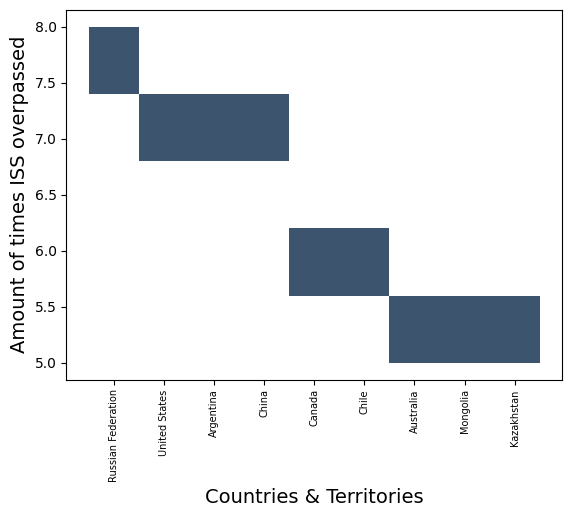

In [88]:
ax = sns.histplot(data=day_dict, x=new_dict.keys(), y=new_dict.values())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Amount of times ISS overpassed", fontsize=14)
plt.show()

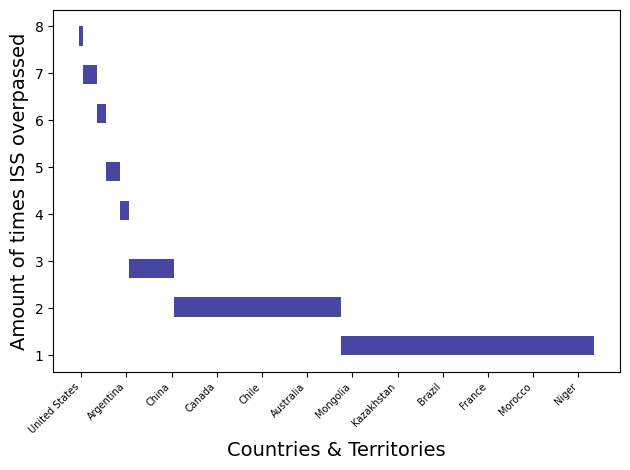

<Figure size 2000x1000 with 0 Axes>

In [89]:
ax = sns.histplot(data=day_dict, x=day_dict.keys(), y=day_dict.values(), color='blue', fill=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontdict={'fontsize': 7}, ha='right')
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Amount of times ISS overpassed", fontsize=14)
ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
plt.tight_layout()
plt.figure(figsize=(20,10))
plt.show()

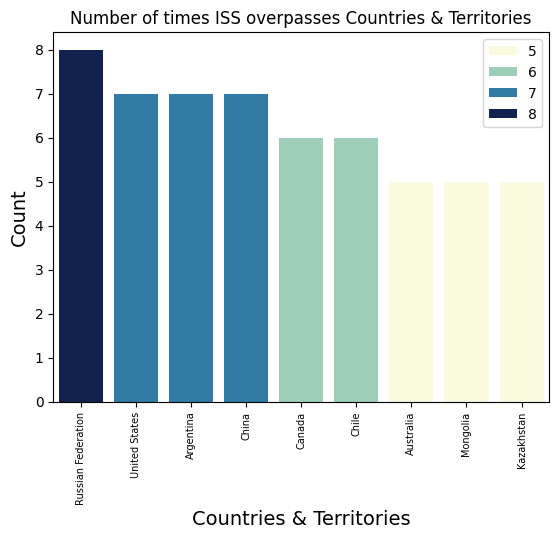

In [90]:
ax = sns.barplot(data=new_dict, x=new_dict.keys(), y=new_dict.values(), palette="YlGnBu", hue=new_dict.values())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Count", fontsize=14, )
plt.title("Number of times ISS overpasses Countries & Territories")
plt.show()

In [91]:
day_df.groupby('Count').sum()

,Countries
Count,
1,MaliCongoGambiaGuinea-BissauGuineaSierra Leone...
2,CameroonAngolaZimbabweSenegalSouth AfricaMalay...
3,"MoroccoNigerNigeriaCongo, The Democratic Repub..."
4,BrazilFrance
5,AustraliaMongoliaKazakhstan
6,CanadaChile
7,United StatesArgentinaChina
8,Russian Federation


In [92]:
day_df

,Countries,Count
0,Russian Federation,8
1,United States,7
2,Argentina,7
3,China,7
4,Canada,6
...,...,...
109,United Arab Emirates,1
110,Oman,1
111,Egypt,1
112,Ethiopia,1


In [177]:
day_group = day_df.groupby('Count').apply(lambda x: x['Countries'] )

In [178]:
day_group

Count    
1      58                  Mali
       59                 Congo
       60                Gambia
       61         Guinea-Bissau
       62                Guinea
                    ...        
6      5                  Chile
7      1          United States
       2              Argentina
       3                  China
8      0     Russian Federation
Name: Countries, Length: 114, dtype: object

In [94]:
day_group[4]

,Countries
9,Brazil
10,France


In [95]:
countone = list()

In [96]:
for element in day_group[1]:
    countone.append(element)


Mali
Congo
Gambia
Guinea-Bissau
Guinea
Sierra Leone
Namibia
Trinidad and Tobago
Guyana
Suriname
French Guiana
Philippines
Guatemala
Nicaragua
Costa Rica
Paraguay
Bhutan
Botswana
Tanzania, United Republic of
South Sudan
Uzbekistan
Ghana
Togo
Benin
Georgia
Korea, Republic of
Uruguay
Mauritania
Bosnia and Herzegovina
Moldova, Republic of
Taiwan
Papua New Guinea
Portugal
Spain
Czech Republic
Kyrgyzstan
Myanmar
Cambodia
Brunei Darussalam
Venezuela
Afghanistan
El Salvador
Cuba
Luxembourg
Austria
Slovenia
Hungary
Bulgaria
Syrian Arab Republic
Kuwait
Qatar
United Arab Emirates
Oman
Egypt
Ethiopia
Chad


In [97]:
countone

['Mali',
 'Congo',
 'Gambia',
 'Guinea-Bissau',
 'Guinea',
 'Sierra Leone',
 'Namibia',
 'Trinidad and Tobago',
 'Guyana',
 'Suriname',
 'French Guiana',
 'Philippines',
 'Guatemala',
 'Nicaragua',
 'Costa Rica',
 'Paraguay',
 'Bhutan',
 'Botswana',
 'Tanzania, United Republic of',
 'South Sudan',
 'Uzbekistan',
 'Ghana',
 'Togo',
 'Benin',
 'Georgia',
 'Korea, Republic of',
 'Uruguay',
 'Mauritania',
 'Bosnia and Herzegovina',
 'Moldova, Republic of',
 'Taiwan',
 'Papua New Guinea',
 'Portugal',
 'Spain',
 'Czech Republic',
 'Kyrgyzstan',
 'Myanmar',
 'Cambodia',
 'Brunei Darussalam',
 'Venezuela',
 'Afghanistan',
 'El Salvador',
 'Cuba',
 'Luxembourg',
 'Austria',
 'Slovenia',
 'Hungary',
 'Bulgaria',
 'Syrian Arab Republic',
 'Kuwait',
 'Qatar',
 'United Arab Emirates',
 'Oman',
 'Egypt',
 'Ethiopia',
 'Chad']

In [98]:
def countby_country(df, count):
    """

    """
    country_list = list()
    for element in df.groupby('Count')[count]:
        country_list.append(element)

In [99]:
grouped_df = day_group.reset_index()
grouped_df

,Count,level_1,Countries
0,1,58,Mali
1,1,59,Congo
2,1,60,Gambia
3,1,61,Guinea-Bissau
4,1,62,Guinea
...,...,...,...
109,6,5,Chile
110,7,1,United States
111,7,2,Argentina
112,7,3,China


In [100]:
len(grouped_df)

114

In [101]:
grouped_df

,Count,level_1,Countries
0,1,58,Mali
1,1,59,Congo
2,1,60,Gambia
3,1,61,Guinea-Bissau
4,1,62,Guinea
...,...,...,...
109,6,5,Chile
110,7,1,United States
111,7,2,Argentina
112,7,3,China


In [102]:
125 % 23

10

In [103]:
23*5

115

### <font color="green"> Bar graphs and Pie charts

In [104]:
def plot_countriesbar(data: pd.DataFrame, n=25):
    """
    This function plots the countries and territories the ISS overpasses. It
    plots n number of countries at a time using seaborn and matplotlib
    Parameters
    ----------
    data : Pandas DataFrame
        A dataframe of countries and territories the ISS overpasses alongside
        how many times it overpasses them.
    n : int
        Number of countries to plot at a time.
    """
    start = 0
    stop = n
    amount = len(data)
    count = amount/n
    while(count>0):
      ax = sns.barplot(data=data[start:stop], x='Countries', y='Count', palette="YlGnBu")
      ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
      plt.xlabel("Countries & Territories", fontsize=14)
      plt.ylabel("Count", fontsize=14, )
      plt.title("Number of times ISS overpasses Countries & Territories")
      plt.show()
      count -= 1
      start += n
      stop += n


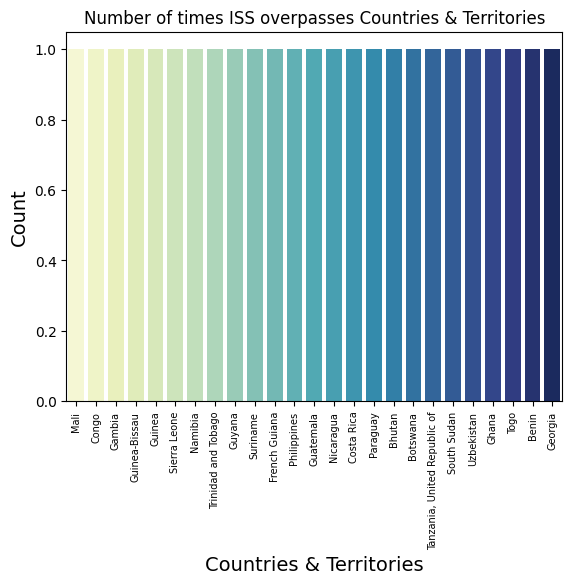

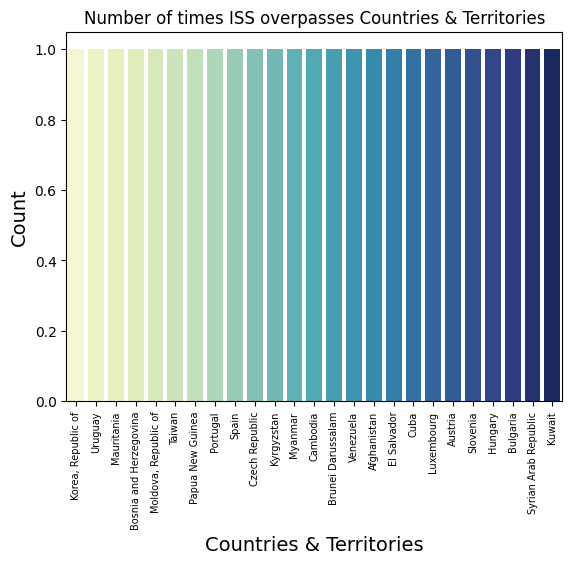

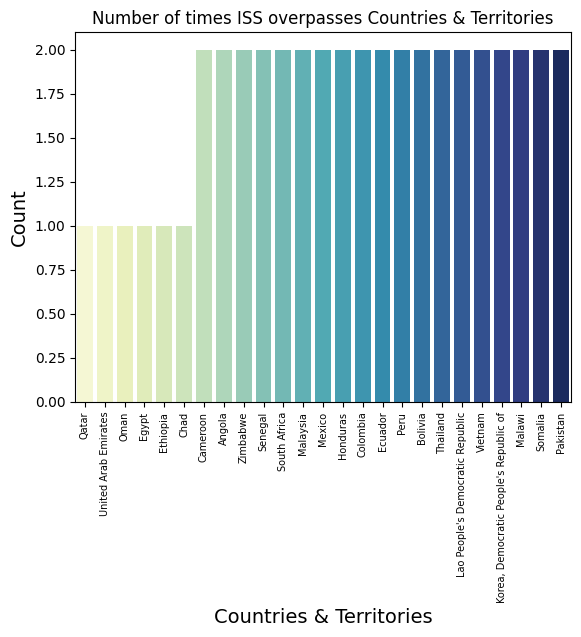

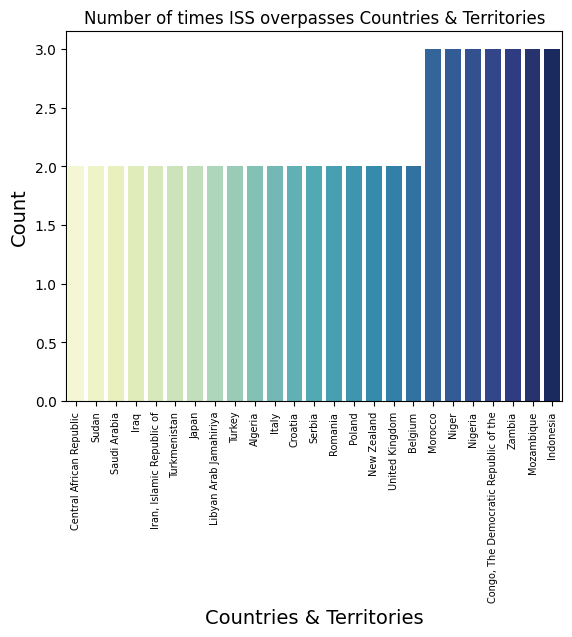

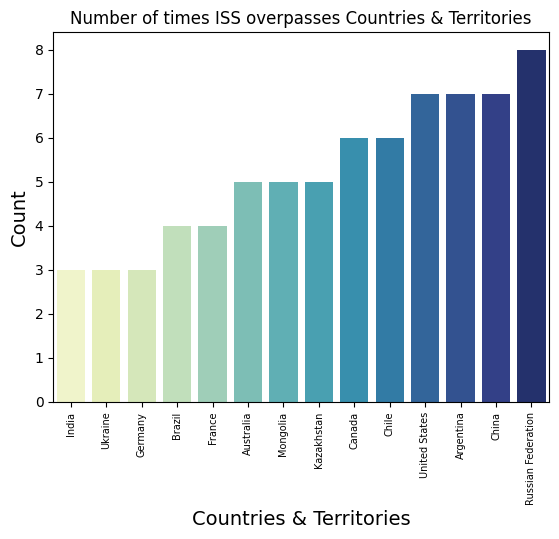

CPU times: user 1.98 s, sys: 41.7 ms, total: 2.02 s
Wall time: 2.04 s


In [105]:
%time plot_countriesbar(grouped_df)

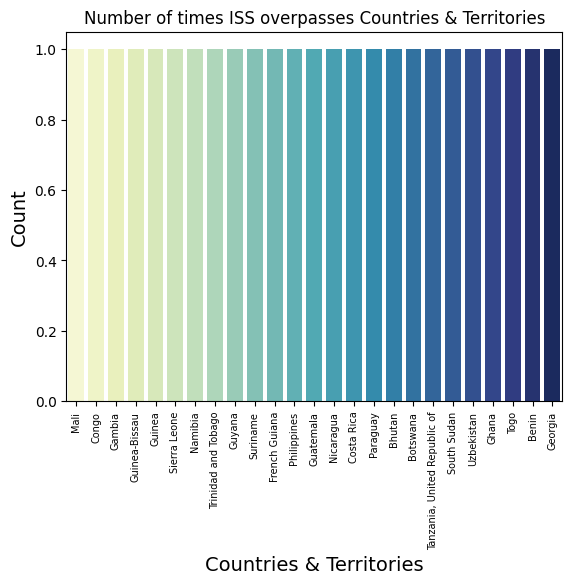

In [106]:
ax = sns.barplot(data=grouped_df[0:25], x='Countries', y='Count', palette="YlGnBu")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Count", fontsize=14, )
plt.title("Number of times ISS overpasses Countries & Territories")
plt.show()

In [107]:
count_group = day_df.groupby('Count').count()

In [108]:
count_group

,Countries
Count,
1,56
2,37
3,10
4,2
5,3
6,2
7,3
8,1


In [109]:
count_df = count_group.reset_index()
count_df

,Count,Countries
0,1,56
1,2,37
2,3,10
3,4,2
4,5,3
5,6,2
6,7,3
7,8,1


In [110]:
len(day_df)

114

Text(0.5, 1.0, '114 Countries & Territories overpassed by the ISS')

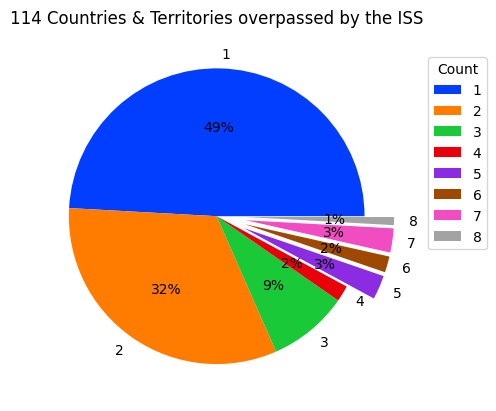

In [111]:
palette_color = sns.color_palette('bright')
explode = [0 for i in range(len(count_df))]
explode[-1] = 0.2
explode[-2] = 0.2
explode[-3] = 0.2
explode[-4] = 0.2
plt.pie(count_df['Countries'], labels=count_df['Count'], colors=palette_color, autopct='%.0f%%', explode=explode)
plt.legend(title = "Count", loc ="best", bbox_to_anchor=(0.80, -0.05, 0.45, 1))
plt.title(f"{len(day_df)} Countries & Territories overpassed by the ISS")

In [112]:
for element in day_group[1]:
    print(element)


Mali
Congo
Gambia
Guinea-Bissau
Guinea
Sierra Leone
Namibia
Trinidad and Tobago
Guyana
Suriname
French Guiana
Philippines
Guatemala
Nicaragua
Costa Rica
Paraguay
Bhutan
Botswana
Tanzania, United Republic of
South Sudan
Uzbekistan
Ghana
Togo
Benin
Georgia
Korea, Republic of
Uruguay
Mauritania
Bosnia and Herzegovina
Moldova, Republic of
Taiwan
Papua New Guinea
Portugal
Spain
Czech Republic
Kyrgyzstan
Myanmar
Cambodia
Brunei Darussalam
Venezuela
Afghanistan
El Salvador
Cuba
Luxembourg
Austria
Slovenia
Hungary
Bulgaria
Syrian Arab Republic
Kuwait
Qatar
United Arab Emirates
Oman
Egypt
Ethiopia
Chad


In [113]:
day_dict.items()

dict_items([('Russian Federation', 8), ('United States', 7), ('Argentina', 7), ('China', 7), ('Canada', 6), ('Chile', 6), ('Australia', 5), ('Mongolia', 5), ('Kazakhstan', 5), ('Brazil', 4), ('France', 4), ('Morocco', 3), ('Niger', 3), ('Nigeria', 3), ('Congo, The Democratic Republic of the', 3), ('Zambia', 3), ('Mozambique', 3), ('Indonesia', 3), ('India', 3), ('Ukraine', 3), ('Germany', 3), ('Cameroon', 2), ('Angola', 2), ('Zimbabwe', 2), ('Senegal', 2), ('South Africa', 2), ('Malaysia', 2), ('Mexico', 2), ('Honduras', 2), ('Colombia', 2), ('Ecuador', 2), ('Peru', 2), ('Bolivia', 2), ('Thailand', 2), ("Lao People's Democratic Republic", 2), ('Vietnam', 2), ("Korea, Democratic People's Republic of", 2), ('Malawi', 2), ('Somalia', 2), ('Pakistan', 2), ('Central African Republic', 2), ('Sudan', 2), ('Saudi Arabia', 2), ('Iraq', 2), ('Iran, Islamic Republic of', 2), ('Turkmenistan', 2), ('Japan', 2), ('Libyan Arab Jamahiriya', 2), ('Turkey', 2), ('Algeria', 2), ('Italy', 2), ('Croatia', 

create new function with country name, return how many time it will fly over that country

In [114]:
for key, value in day_dict.items():
  print(f"Key:{key}, Value:{value}")

Key:Russian Federation, Value:8
Key:United States, Value:7
Key:Argentina, Value:7
Key:China, Value:7
Key:Canada, Value:6
Key:Chile, Value:6
Key:Australia, Value:5
Key:Mongolia, Value:5
Key:Kazakhstan, Value:5
Key:Brazil, Value:4
Key:France, Value:4
Key:Morocco, Value:3
Key:Niger, Value:3
Key:Nigeria, Value:3
Key:Congo, The Democratic Republic of the, Value:3
Key:Zambia, Value:3
Key:Mozambique, Value:3
Key:Indonesia, Value:3
Key:India, Value:3
Key:Ukraine, Value:3
Key:Germany, Value:3
Key:Cameroon, Value:2
Key:Angola, Value:2
Key:Zimbabwe, Value:2
Key:Senegal, Value:2
Key:South Africa, Value:2
Key:Malaysia, Value:2
Key:Mexico, Value:2
Key:Honduras, Value:2
Key:Colombia, Value:2
Key:Ecuador, Value:2
Key:Peru, Value:2
Key:Bolivia, Value:2
Key:Thailand, Value:2
Key:Lao People's Democratic Republic, Value:2
Key:Vietnam, Value:2
Key:Korea, Democratic People's Republic of, Value:2
Key:Malawi, Value:2
Key:Somalia, Value:2
Key:Pakistan, Value:2
Key:Central African Republic, Value:2
Key:Sudan, V

In [115]:
def count_countryoverpass(count_dict: dict, country: str) -> int:
    """
    Counts the amount of times the ISS flies over a country.

    Parameters
    ----------
    count_dict : Dictionary

    Return
    ------
    count : Int
        The number of times the ISS passes over a country.
    """


    for key, value in count_dict.items():
        if key == country:
            return value
    print("Country not found")
    return 0

In [116]:
count_countryoverpass(day_dict, "United States")

7

given latitude and longitude return how many times the ISS will fly over it

In [117]:
day_df

,Countries,Count
0,Russian Federation,8
1,United States,7
2,Argentina,7
3,China,7
4,Canada,6
...,...,...
109,United Arab Emirates,1
110,Oman,1
111,Egypt,1
112,Ethiopia,1


Create function with one indivudual orbit and name of country, Return nothing or date.

Create function that determine the next times the ISS will overpass a country name. Will return:
- Dates
- None

Loop over Orbits

May create function see when the ISS leave the country

In [118]:
interpolated_list[4]

,lat,lon,land_flag,Country
t,,,,
2025-04-04 17:48:05,-22.457605,-168.551247,False,Ocean
2025-04-04 17:48:25,-21.470379,-167.757177,False,Ocean
2025-04-04 17:48:45,-20.483152,-166.963108,False,Ocean
2025-04-04 17:49:05,-19.495926,-166.169038,False,Ocean
2025-04-04 17:49:25,-18.508699,-165.374969,False,Ocean
...,...,...,...,...
2025-04-04 19:22:25,-18.164381,171.269950,False,Ocean
2025-04-04 19:22:45,-17.188583,172.090441,False,Ocean
2025-04-04 19:23:05,-16.212785,172.910932,False,Ocean


In [119]:
single_orbit_df = interpolated_list[4]

In [120]:
%time single_orbit_df['land_flag'] = single_orbit_df.apply(get_land_flag, axis=1, result_type='expand')
%time single_orbit_df['Country'] = single_orbit_df.apply(obtain_country_name, axis=1, result_type='expand')

CPU times: user 89.4 ms, sys: 1.96 ms, total: 91.4 ms
Wall time: 112 ms
CPU times: user 12.2 ms, sys: 785 µs, total: 13 ms
Wall time: 16.6 ms


In [121]:
def get_country_time(orbit_df: pd.DataFrame, country: str):
    """
    This function returns the time the ISS will fly over a country given the
    orbit and country name.

    Parameters
    ----------
    orbit_df : Pandas DataFrame
        A dataframe of a single orbit of the ISS path.
    country : str
        Name of country to search for.

    Return
    ------
    index : str
        A timestamp turned into a string of the time the ISS will fly over
        the country.
    """
    for index, row in orbit_df.iterrows():
        if country in row['Country']:
            return str(index)
    return None

In [122]:
get_country_time(single_orbit_df, 'United States')

'2025-04-04 18:07:45'

In [123]:
day_df2 = get_range(df, start_date, end_date)

2025-04-08 16:39:56
2025-04-09 16:39:56
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [124]:
%time day_df2['land_flag'] = day_df2.apply(get_land_flag, axis=1, result_type='expand')
%time day_df2['Country'] = day_df2.apply(obtain_country_name, axis=1, result_type='expand')

CPU times: user 113 ms, sys: 1.97 ms, total: 115 ms
Wall time: 130 ms
CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 15.2 ms


In [125]:
day_df2

,Date,lat,lon,land_flag,Country
0,2025-04-08 16:39:56,48.288537,-93.940371,True,United States
1,2025-04-08 16:43:56,51.710255,-71.352140,True,Canada
2,2025-04-08 16:47:56,50.026151,-47.876859,False,Ocean
3,2025-04-08 16:51:56,43.802172,-28.031314,False,Ocean
4,2025-04-08 16:55:56,34.581017,-12.892996,False,Ocean
...,...,...,...,...,...
356,2025-04-09 16:23:56,-8.904937,29.251245,True,Zambia
357,2025-04-09 16:27:56,-20.818062,38.565633,False,Ocean
358,2025-04-09 16:31:56,-31.986757,49.580838,False,Ocean
359,2025-04-09 16:35:56,-41.702276,63.655964,False,Ocean


In [126]:
def get_country_time2(orbits_list: list, country: str):
    """
    This function returns list of all the times the ISS will fly over a country
    given the orbit and country name.

    Parameters
    ----------
    orbits_list: list
        A list of the ISS path.
    country : str
        Name of country to search for.

    Return
    ------
    ___ : list
        A list of times the ISS will fly over the country.
    """

    country_list = list()
    for df in orbits_list:
        for index, row in df.iterrows():
            if country in row['Country']:
                country_list.append(str(index))

    return country_list

In [127]:
get_country_time2(interpolated_list[4:7], 'United States')

['2025-04-04 18:07:45',
 '2025-04-04 18:08:05',
 '2025-04-04 18:08:25',
 '2025-04-04 18:08:45',
 '2025-04-04 18:09:05',
 '2025-04-04 18:09:25',
 '2025-04-04 18:09:45',
 '2025-04-04 18:10:05',
 '2025-04-04 18:10:25',
 '2025-04-04 18:10:45',
 '2025-04-04 18:11:05',
 '2025-04-04 18:11:25',
 '2025-04-04 18:11:45',
 '2025-04-04 18:12:05',
 '2025-04-04 18:12:25',
 '2025-04-04 18:12:45',
 '2025-04-04 18:13:05',
 '2025-04-04 18:13:25',
 '2025-04-04 18:13:45',
 '2025-04-04 18:14:05',
 '2025-04-04 19:45:45',
 '2025-04-04 19:46:05',
 '2025-04-04 19:46:25',
 '2025-04-04 19:46:45',
 '2025-04-04 19:47:05',
 '2025-04-04 19:47:25',
 '2025-04-04 21:28:45',
 '2025-04-04 21:29:25',
 '2025-04-04 21:29:45',
 '2025-04-04 21:31:45',
 '2025-04-04 21:32:05',
 '2025-04-04 21:32:25',
 '2025-04-04 21:32:45']

In [128]:
df

,Date,lat,lon
0,2025-04-04 12:00:00,44.020853,-11.557049
1,2025-04-04 12:04:00,50.141197,8.427171
2,2025-04-04 12:08:00,51.683332,31.944275
3,2025-04-04 12:12:00,48.134005,54.425880
4,2025-04-04 12:16:00,40.598278,72.426740
...,...,...,...
5398,2025-04-19 11:46:00,-27.266370,57.360652
5399,2025-04-19 11:50:00,-37.725036,69.922871
5400,2025-04-19 11:54:00,-46.140094,86.393131
5401,2025-04-19 11:58:00,-51.087085,107.570938


In [129]:
interpolated_list[4]

,lat,lon,land_flag,Country
t,,,,
2025-04-04 17:48:05,-22.457605,-168.551247,False,Ocean
2025-04-04 17:48:25,-21.470379,-167.757177,False,Ocean
2025-04-04 17:48:45,-20.483152,-166.963108,False,Ocean
2025-04-04 17:49:05,-19.495926,-166.169038,False,Ocean
2025-04-04 17:49:25,-18.508699,-165.374969,False,Ocean
...,...,...,...,...
2025-04-04 19:22:25,-18.164381,171.269950,False,Ocean
2025-04-04 19:22:45,-17.188583,172.090441,False,Ocean
2025-04-04 19:23:05,-16.212785,172.910932,False,Ocean


In [130]:
test_list = interpolated_list[4:8]

In [131]:
test_list

[                           lat         lon  land_flag Country
 t                                                            
 2025-04-04 17:48:05 -22.457605 -168.551247      False   Ocean
 2025-04-04 17:48:25 -21.470379 -167.757177      False   Ocean
 2025-04-04 17:48:45 -20.483152 -166.963108      False   Ocean
 2025-04-04 17:49:05 -19.495926 -166.169038      False   Ocean
 2025-04-04 17:49:25 -18.508699 -165.374969      False   Ocean
 ...                        ...         ...        ...     ...
 2025-04-04 19:22:25 -18.164381  171.269950      False   Ocean
 2025-04-04 19:22:45 -17.188583  172.090441      False   Ocean
 2025-04-04 19:23:05 -16.212785  172.910932      False   Ocean
 2025-04-04 19:23:25 -15.236987  173.731423      False   Ocean
 2025-04-04 19:23:45 -14.261189  174.551914      False   Ocean
 
 [288 rows x 4 columns],
                            lat         lon  land_flag Country
 t                                                            
 2025-04-04 19:28:05  -1.121

In [132]:
test_df = interpolated_list[4]

In [133]:
test_df

,lat,lon,land_flag,Country
t,,,,
2025-04-04 17:48:05,-22.457605,-168.551247,False,Ocean
2025-04-04 17:48:25,-21.470379,-167.757177,False,Ocean
2025-04-04 17:48:45,-20.483152,-166.963108,False,Ocean
2025-04-04 17:49:05,-19.495926,-166.169038,False,Ocean
2025-04-04 17:49:25,-18.508699,-165.374969,False,Ocean
...,...,...,...,...
2025-04-04 19:22:25,-18.164381,171.269950,False,Ocean
2025-04-04 19:22:45,-17.188583,172.090441,False,Ocean
2025-04-04 19:23:05,-16.212785,172.910932,False,Ocean


In [134]:
test_df[205:206]['Country']

,Country
t,
2025-04-04 18:56:25,Ocean


In [135]:
test_list

[                           lat         lon  land_flag Country
 t                                                            
 2025-04-04 17:48:05 -22.457605 -168.551247      False   Ocean
 2025-04-04 17:48:25 -21.470379 -167.757177      False   Ocean
 2025-04-04 17:48:45 -20.483152 -166.963108      False   Ocean
 2025-04-04 17:49:05 -19.495926 -166.169038      False   Ocean
 2025-04-04 17:49:25 -18.508699 -165.374969      False   Ocean
 ...                        ...         ...        ...     ...
 2025-04-04 19:22:25 -18.164381  171.269950      False   Ocean
 2025-04-04 19:22:45 -17.188583  172.090441      False   Ocean
 2025-04-04 19:23:05 -16.212785  172.910932      False   Ocean
 2025-04-04 19:23:25 -15.236987  173.731423      False   Ocean
 2025-04-04 19:23:45 -14.261189  174.551914      False   Ocean
 
 [288 rows x 4 columns],
                            lat         lon  land_flag Country
 t                                                            
 2025-04-04 19:28:05  -1.121

In [136]:
def get_country_entrance(df_orbit: pd.DataFrame, country_name: str):
    """
    This function returns list of times the ISS FIRST flies over a country given
    the orbit and country name.
    Parameters
    ----------
    df_orbit: list
        A list of the ISS path.
    country_name : str
        Name of country to search for.
    Return
    ------
    ___ : list
        A list of times the ISS will fly over the country.
    """
    country_list = df_orbit['Country'].unique().tolist()
    if country_name in country_list:
        filtered_df = df_orbit[df_orbit['Country'] == country_name]
        if 't' in filtered_df.columns:
            return filtered_df['t'].iloc[0], filtered_df['t'].iloc[-1]
        else:
            return filtered_df.index[0], filtered_df.index[-1]

    else:
        return None



In [137]:
get_country_entrance(interpolated_list[4], 'Canada')

(Timestamp('2025-04-04 18:14:25'), Timestamp('2025-04-04 18:20:05'))

In [138]:
def get_country_entrance2(orbits_list: list, country_name: str):
    """
    This function returns list of times the ISS FIRST flies over a country given
    the orbit and country name.

    Parameters
    ----------
    orbits_list: list
        A list of the ISS path.
    country : str
        Name of country to search for.

    Return
    ------
    ___ : list
        A list of times the ISS will fly over the country.
    """

    date_list = list()
    for func_df in orbits_list:
        dates = get_country_entrance(func_df, country_name)
        if dates:
            #print(dates)
            date_list.append(dates)

    return date_list

In [139]:
%time get_country_entrance2(interpolated_list, 'United Kingdom')

CPU times: user 30.1 ms, sys: 0 ns, total: 30.1 ms
Wall time: 36.6 ms


[(Timestamp('2025-04-04 13:38:45'), Timestamp('2025-04-04 13:39:25')),
 (Timestamp('2025-04-04 15:15:45'), Timestamp('2025-04-04 15:15:45')),
 (Timestamp('2025-04-05 12:51:05'), Timestamp('2025-04-05 12:51:45')),
 (Timestamp('2025-04-05 14:28:05'), Timestamp('2025-04-05 14:28:25')),
 (Timestamp('2025-04-06 13:40:05'), Timestamp('2025-04-06 13:41:05')),
 (Timestamp('2025-04-07 12:52:45'), Timestamp('2025-04-07 12:53:05')),
 (Timestamp('2025-04-08 12:04:41'), Timestamp('2025-04-08 12:05:21')),
 (Timestamp('2025-04-09 11:16:41'), Timestamp('2025-04-09 11:16:41')),
 (Timestamp('2025-04-09 12:53:41'), Timestamp('2025-04-09 12:53:41')),
 (Timestamp('2025-04-10 12:06:01'), Timestamp('2025-04-10 12:06:21')),
 (Timestamp('2025-04-11 11:18:01'), Timestamp('2025-04-11 11:18:41')),
 (Timestamp('2025-04-12 10:30:01'), Timestamp('2025-04-12 10:30:41')),
 (Timestamp('2025-04-13 11:19:01'), Timestamp('2025-04-13 11:19:21')),
 (Timestamp('2025-04-14 10:31:21'), Timestamp('2025-04-14 10:31:41')),
 (Time

In [140]:
def return_position(df: pd.DataFrame, lat: float, lon: float) -> str:
    """

    """
    min_lat = lat - 0.2896
    max_lat = lat + 0.2896
    min_lon = lon - 0.2896
    max_lon = lon + 0.2896
    print(df)
    for lat_element in df['lat']:
        if lat_element >= min_lat and lat_element <= max_lat:
            print(lat_element)
            break
            #for lon_element in df['lon']:
            #  if lon_element['lon'] >= min_lon and lon_element['lon'] <= max_lon:
            #      print(lon_element)
    for lon_element in df['lon']:
              print("Past lon")
              if lon_element['lon'] >= min_lon and lon_element['lon'] <= max_lon:
                  print(lon_element)
                  break
              print("Past if")
    print("Ran")









In [141]:
return_position(day_df, 39.9072, -71.0369)

                Countries  Count
0      Russian Federation      8
1           United States      7
2               Argentina      7
3                   China      7
4                  Canada      6
..                    ...    ...
109  United Arab Emirates      1
110                  Oman      1
111                 Egypt      1
112              Ethiopia      1
113                  Chad      1

[114 rows x 2 columns]


KeyError: 'lat'

besides a pie chart come up with 2 graphs to represent amount of times the ISS overpass a specific country

some ways is scatterplot(each datapoint is colored) and barplot (explore more options)

In [146]:
group_list = interpolated_list

In [148]:
group_list[0]

,lat,lon,land_flag,Country
t,,,,
2025-04-04 12:00:05,44.148360,-11.140711,False,Ocean
2025-04-04 12:00:25,44.658389,-9.475359,False,Ocean
2025-04-04 12:00:45,45.168418,-7.810008,False,Ocean
2025-04-04 12:01:05,45.678446,-6.144656,False,Ocean
2025-04-04 12:01:25,46.188475,-4.479304,False,Ocean
...,...,...,...,...
2025-04-04 12:46:25,-43.620911,157.090572,False,Ocean
2025-04-04 12:46:45,-44.298481,158.503173,False,Ocean
2025-04-04 12:47:05,-44.976051,159.915774,False,Ocean


In [187]:
country_dict = get_all_countrys(group_list)

In [189]:
country_dict

{'France': 45,
 'Germany': 40,
 'Czech Republic': 23,
 'Poland': 28,
 'Ukraine': 51,
 'Russian Federation': 111,
 'Kazakhstan': 75,
 'Uzbekistan': 31,
 'Kyrgyzstan': 12,
 'China': 106,
 'India': 45,
 'Bangladesh': 7,
 'Myanmar': 11,
 'Thailand': 22,
 'Cambodia': 10,
 'Malaysia': 20,
 'Indonesia': 61,
 'Australia': 70,
 'Colombia': 23,
 'United Kingdom': 20,
 'Netherlands': 5,
 'Georgia': 9,
 'Azerbaijan': 13,
 'Iran, Islamic Republic of': 38,
 'Afghanistan': 22,
 'Pakistan': 28,
 'Mexico': 41,
 'United States': 105,
 'Switzerland': 9,
 'Italy': 28,
 'Croatia': 8,
 'Bosnia and Herzegovina': 9,
 'Montenegro': 2,
 'Kosovo': 4,
 'Macedonia': 4,
 'Greece': 13,
 'Turkey': 34,
 'Cyprus': 5,
 'Lebanon': 2,
 'Jordan': 6,
 'Saudi Arabia': 27,
 'Yemen': 16,
 'Canada': 79,
 'Spain': 25,
 'Algeria': 36,
 'Tunisia': 12,
 'Libyan Arab Jamahiriya': 35,
 'Chad': 25,
 'Sudan': 27,
 'South Sudan': 16,
 'Ethiopia': 17,
 'Kenya': 15,
 'Somalia': 23,
 'Madagascar': 12,
 'Morocco': 22,
 'Mali': 26,
 'Niger':

In [202]:
def groupby_listtodf(grouped_dict: dict):
    #group_items = sorted(grouped_dict.items(), key=lambda x: x[1], reverse=True)
    #group_df = pd.DataFrame(group_items, columns=['Countries', 'Count'])
    #group_dict = get_all2(group_df, seconds='15s')
    grouped_items = sorted(grouped_dict.items(), key=lambda x: x[1], reverse=True)
    grouped_df = pd.DataFrame(grouped_items, columns=['Countries', 'Count'])
    element_group = grouped_df.groupby('Count').apply(lambda x: x['Countries'] )
    return element_group.reset_index()


In [203]:
%time new_groupby_df = groupby_listtodf(country_dict)

CPU times: user 12.9 ms, sys: 0 ns, total: 12.9 ms
Wall time: 16.8 ms


In [204]:
new_groupby_df

,Count,level_1,Countries
0,1,154,Fiji
1,1,155,Mauritius
2,1,156,Swaziland
3,1,157,Timor-Leste
4,1,158,Saint Pierre and Miquelon
...,...,...,...
160,79,4,Canada
161,91,3,Argentina
162,105,2,United States
163,106,1,China


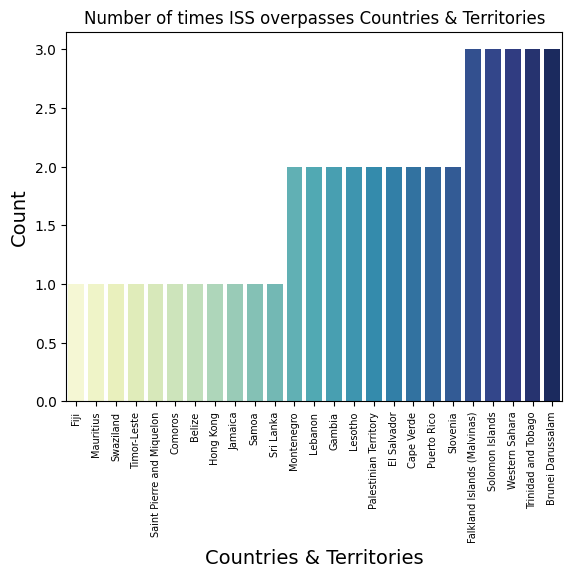

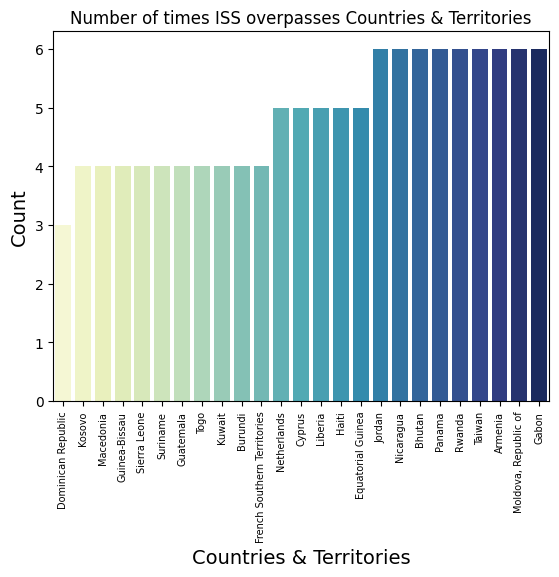

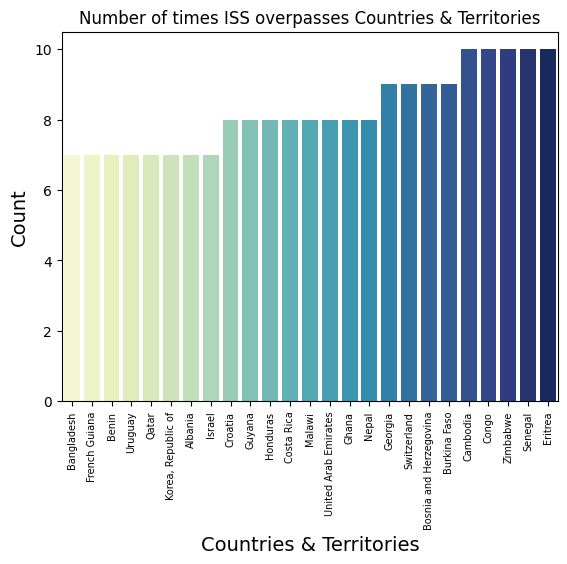

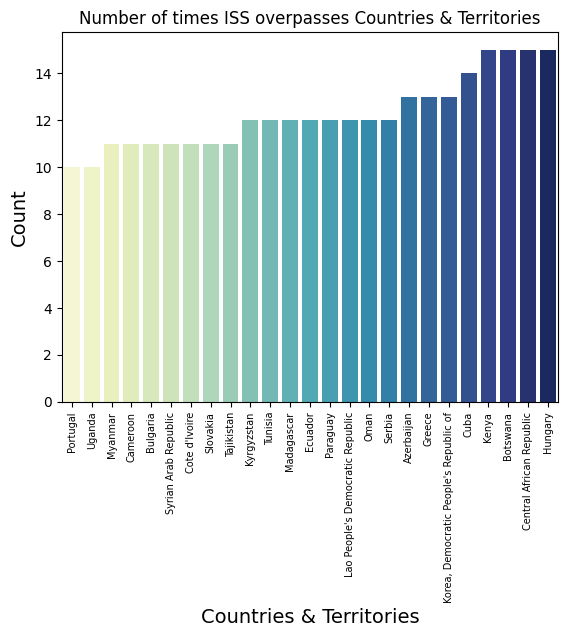

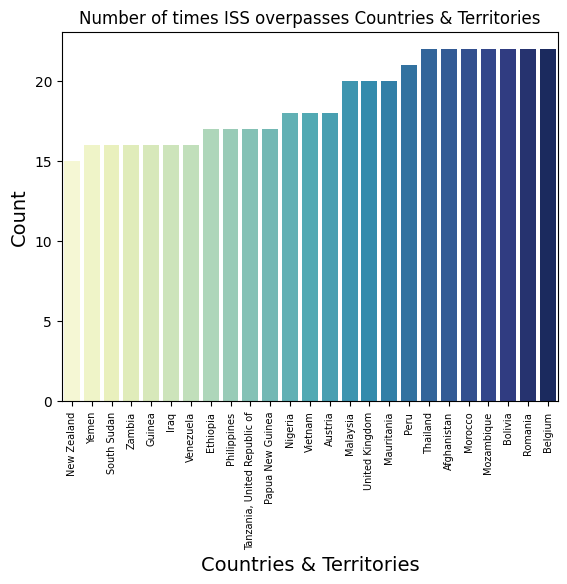

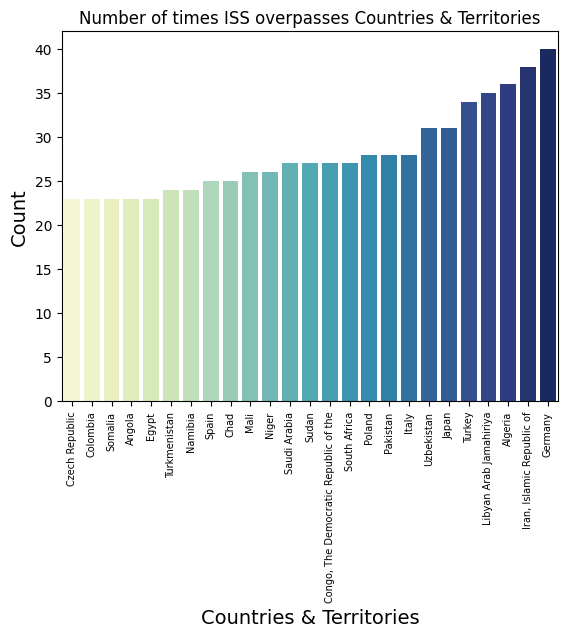

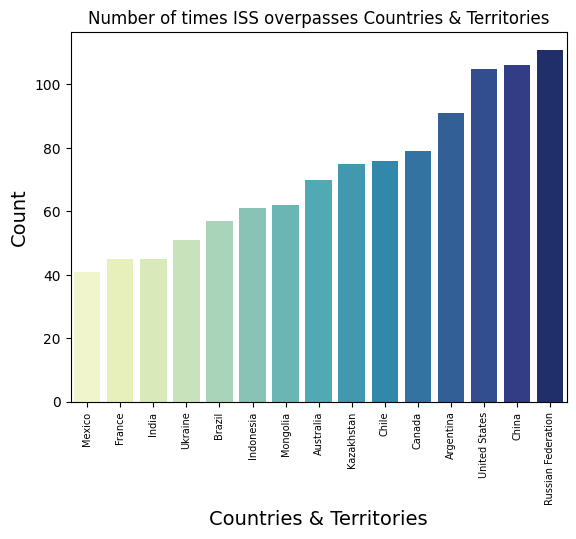

CPU times: user 3.87 s, sys: 46.6 ms, total: 3.92 s
Wall time: 4.76 s


In [205]:
# Note: Add a title argument for the function
%time plot_countriesbar(new_groupby_df)

within the radius of 20 miles of a specific point how many times will the ISS fly over.

In [ ]:
test_date = '2025-02-13 15:00:00'
test_date = dt.datetime.strptime(test_date, '%Y-%m-%d %H:%M:%S')

In [ ]:
test_date

In [ ]:
df['Date'].loc(test_date)

In [ ]:
type(test_date)

In [ ]:
df['Date'].info()